## Probelm 3

### 3a. Use the FashionMNIST training dataset (which we used in previous assign- ments) to train the DCGAN. Images are grayscale and size 28 × 28.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import random

torch.Size([1, 28, 28])


<function matplotlib.pyplot.show(close=None, block=None)>

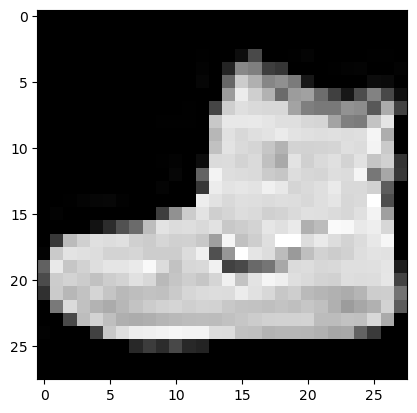

In [23]:
## download the data
train_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

image, label = trainingdata[0]
print(image.size())

plt.imshow(image.squeeze(), cmap=plt.cm.gray)
plt.show

## 3b.

Use the following discriminator architecture (kernel size = 5 × 5 with stride = 2 in both directions):

- 2D convolutions(1×28×28→64×14×14→128×7×7)
- each convolutional layer is equipped with a Leaky ReLU with slope 0.3, followed by Dropout with parameter 0.3.
- a dense layer that takes the flattened output of the last convolution and maps it to a scalar.


In [8]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        
        # Define Leaky ReLU and Dropout
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.dropout = nn.Dropout(0.3)
        
        # Define the dense layer
        self.dense = nn.Linear(128*7*7, 1)  # 128 channels, 7x7 feature map
        
    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        # Flatten the output for the dense layer
        x = torch.flatten(x, 1)
        
        # Forward pass through the dense layer
        x = self.dense(x)
        
        return x


## 2.c

Use the following generator architecture (which is essentially the reverse of a standard discriminative architecture). You can use the same kernel size. Construct:

- a dense layer that takes a unit Gaussian noise vector of length 100 and maps it to a vector of size $(7 \times 7 \times 256)$. No bias terms.
- several transpose 2D convolutions $(256 \times 7 \times 7 \rightarrow 128 \times 7 \times 7 \rightarrow 64 \times 14 \times 14 \rightarrow 1 \times 28 \times 28)$. No bias terms.
- each convolutional layer (except the last one) is equipped with Batch Normalization (batch norm), followed by Leaky ReLU with slope $0.3$. The last (output) layer is equipped with tanh activation (no batch norm).

In [11]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim=100, output_channels=1):
        super(Generator, self).__init__()
        
        # Define the dense layer
        self.dense = nn.Linear(input_dim, 7*7*256, bias=False)
        
        # Define the transpose convolutional layers
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.conv3 = nn.ConvTranspose2d(64, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        
        # Define batch normalization
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(64)
        
        # Define Leaky ReLU
        self.leaky_relu = nn.LeakyReLU(0.3)
        
        # Define tanh activation
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Forward pass through the dense layer
        x = self.dense(x)
        x = x.view(-1, 256, 7, 7)  # Reshape to 4D tensor
        
        # Forward pass through transpose convolutional layers
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        
        x = self.conv3(x)
        x = self.tanh(x)
        
        return x


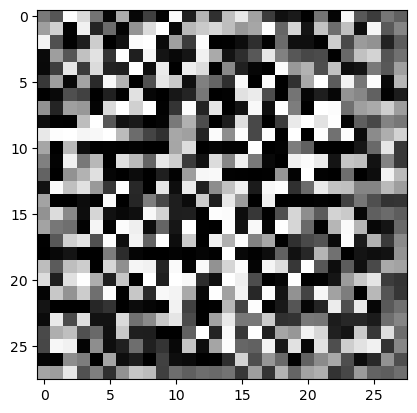

In [21]:
# Define the dimensionality of the noise vector
noise_dim = 100

# Create a random noise vector
noise = torch.randn(1, noise_dim)

# Instantiate the Generator
generator = Generator(input_dim=noise_dim, output_channels=1)

# Generate an image using the noise vector
generated_image = generator(noise)

random_img = generated_image.detach().numpy()
# Display the generated image shape
plt.imshow(random_img.squeeze(), cmap=plt.cm.gray)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')

# Set random seed for reproducibility
torch.manual_seed(0)

# Define the parameters
batch_size = 32
noise_dim = 100
lr = 10e-4
num_epochs = 20

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5), (0.5,0.5))
])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# Instantiate the discriminator and generator
discriminator = Discriminator().to(device)
generator = Generator(input_dim=noise_dim).to(device)

# Define the loss function (binary cross-entropy)
criterion = nn.BCEWithLogitsLoss().to(device)

# Define optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

# Training and testing loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        
        # Train the discriminator
        discriminator.zero_grad()
        
        # Real images
        real_labels = torch.ones(batch_size, 1).to(device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        
        # Fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # Train the generator
        generator.zero_grad()
        
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise).to(device)
        labels = torch.ones(batch_size, 1).to(device)  # We want the generator to fool the discriminator
        output = discriminator(fake_images)
        g_loss = criterion(output, labels)
        g_loss.backward()
        g_optimizer.step()
        
        # Print progress every few batches
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(train_loader)}], "
                  f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
        
    # Save generated images at the end of each epoch
    with torch.no_grad():
        fake = generator(torch.randn(64, noise_dim)).to(device)
        vutils.save_image(fake, f"generated_images_epoch_{epoch+1}.png", normalize=True)

    # Visualize generated images for every few epochs
    if epoch % 5 == 0:
        plt.figure(figsize=(8, 8))
        generator.eval()
        with torch.no_grad():
            noise = torch.randn(25, noise_dim).to(device)
            generated_images = generator(noise).cpu().detach()
            for i in range(25):
                plt.subplot(5, 5, i + 1)
                plt.imshow(generated_images[i].view(28, 28), cmap='gray')
                plt.axis('off')
        plt.show()

print("Training finished.")

# Generate and visualize some images after training
plt.figure(figsize=(8, 8))
generator.eval()
with torch.no_grad():
    noise = torch.randn(25, noise_dim)
    generated_images = generator(noise).cpu().detach()
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i].view(28, 28), cmap='gray')
        plt.axis('off')
plt.show()


Epoch [0/20], Batch [0/1875], Discriminator Loss: 1.4178, Generator Loss: 0.9910
Epoch [0/20], Batch [100/1875], Discriminator Loss: 0.0597, Generator Loss: 11.6814
Epoch [0/20], Batch [200/1875], Discriminator Loss: 0.0567, Generator Loss: 6.8117
Epoch [0/20], Batch [300/1875], Discriminator Loss: 0.0334, Generator Loss: 8.4362
Epoch [0/20], Batch [400/1875], Discriminator Loss: 0.1008, Generator Loss: 13.4678


KeyboardInterrupt: 